# S10 | Integrated Project 2

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We are preparing data to train a model for the company <b>Zyfra</b> which develops efficiency solutions for heavy metal industries.<br>

The model's goal is to predict the amount of gold recovered from gold ore.

<u>We will perform the following tasks</u>:
1. Validate that the recovery values were calculated correctly in the training set
2. Compare the calculated values to the original recovery values and describe their relationship
3. Perform preprocessing to ensure datasets are primed for analysis and manipulation
4. Analyze the Data
5. Train different models, evaluate them using cross-validation, and choose the best for this instance
6. Provide final findings and conclusions

</div>

## Preparing the Data

In [6]:
# Library and Package imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor

In [8]:
# Importing datasets
# Used the "date" column as the index and parsing dates

train_data = pd.read_csv('gold_recovery_train.csv', index_col='date', parse_dates=True)
test_data = pd.read_csv('gold_recovery_test.csv', index_col='date', parse_dates=True)
full_data = pd.read_csv('gold_recovery_full.csv', index_col='date', parse_dates=True)

### Validating Recovery Values

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Reviewing the recovery calculation within the training set to ensure proper model training later in this project. The feature we're focusing on is "<b>rougher.output.recovery</b>". <br>

After, we will find the <b>MAE</b> between the calculations and the actual feature values and will describe their relationship.

</div>

#### Creating a Recovery Function

In [15]:
# Recovery Calculation Function

def recovery(C, F, T):
    
    if abs(F) < .001:
        return 0
    
    elif abs(F - T) < .001:
        return 0

    elif abs(C - T) < .001:
        return 0
    
    num = C * (F - T)
    den = F * (C - T)
    result = (num / den) * 100
    
    return result

<div style="border: 2px solid black; padding: 10px; margin: 10px">

<b><u>C</u></b> | % of Gold in Concentrate <br>
"Rougher Concetrate Recovery" = share of gold in concentrate <b>right after flotation</b> (<i>rougher.output.concentrate_au</i>) <br>
"Final Concentrate Recovery" = share of gold in concentrate <b>after purification</b> (<i>final.output.concentrate_au</i>) <br>

<b><u>F</u></b> | % of Gold in Feed <br>
"Rougher Concetrate Recovery" = share of gold in feed <b>before flotation</b> (<i>rougher.input.feed_au</i>) <br>
"Final Concentrate Recovery" = share of gold in concentrate <b>right after flotation</b> (<i>rougher.output.concetrate_au</i>) <br>

<b><u>T</u></b> | % of Gold in Tails <br>
"Rougher Concetrate Recovery" = share of gold in the rougher tails <b>right after flotation</b> (<i>rougher.output.tail_au</i>) <br>
"Final Concentrate Recovery" = share of gold in the rougher tails <b>after purification</b> (<i>secondary_cleaner.output.tail_au</i>)

<br>

<u>Calculation explanation</u>:
* <b><i>(F - T)</b></i> - represents the amount of gold was lost from the original feed
* <b><i>(C - T)</i>, Enrichment Factor</b> - represents how much concentrate is "enriched" compared to the tails <br>

The formula is calculating the percentage of the gold that was <b>actually recovered</b> compared to the total amount of gold the could have <b>potentially</b> been recovered.

</div>

#### Validating Data Before Calculations

In [20]:
# Checking for missing values before running function



print(train_data['rougher.output.concentrate_au'].isna().sum())
print(train_data['rougher.input.feed_au'].isna().sum())
print(train_data['rougher.output.tail_au'].isna().sum())

82
83
2249


<div style="border: 2px solid black; padding: 10px; margin: 10px">

We are going to use a "forward fill" method to address the missing values in these columns.  

</div>

In [23]:
# Forward Filling the missing values in the train data columns

train_data['rougher.output.concentrate_au'] = train_data['rougher.output.concentrate_au'].fillna(method='ffill')
train_data['rougher.input.feed_au'] = train_data['rougher.input.feed_au'].fillna(method='ffill')
train_data['rougher.output.tail_au'] = train_data['rougher.output.tail_au'].fillna(method='ffill')

/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_83222/1703311022.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['rougher.output.concentrate_au'] = train_data['rougher.output.concentrate_au'].fillna(method='ffill')
/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_83222/1703311022.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['rougher.input.feed_au'] = train_data['rougher.input.feed_au'].fillna(method='ffill')
/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_83222/1703311022.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data['rougher.output.tail_au'] = train_data['rougher.output.tail_au'].fillna(method='ffill')


In [25]:
# Validating that there are no missing values after the "forward fill"

print(train_data['rougher.output.concentrate_au'].isna().sum())
print(train_data['rougher.input.feed_au'].isna().sum())
print(train_data['rougher.output.tail_au'].isna().sum())

0
0
0


<div style="border: 2px solid black; padding: 10px; margin: 10px">

We have forward-filled the missing values in the three columns needed to run the recovery function successfully (and validated that through checking once more for missing values). We can now move forward to calculating the recovery values using our recovery function and then comparing them to the ones already in the dataset.

</div>

#### Calculating Recovery Values

In [30]:
# Calculating recovery values from the "rougher.output.recovery" feature in training set

train_data['calculated_recovery'] = train_data.apply(lambda row: 
                                                     recovery(row['rougher.output.concentrate_au'], 
                                                              row['rougher.input.feed_au'], 
                                                              row['rougher.output.tail_au']), 
                                                     axis=1)

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Recovery values have been calculated and a new column created. <br>

Before completing this portion of the project there was an issue with diving by zero in the recovery function. This was corrected by applying a condition to the recovery function: "if F == 0: return 0". This successfully solved this issue and told Python that if there is a zero, to return the value 0.

</div>

#### Comparing MAE's

In [35]:
# Calculating the MAE for each column and comparing

mae = (train_data['calculated_recovery'] - train_data['rougher.output.recovery']).abs().mean()

print('Difference between the Expected value and Measured value is {}'.format(mae))

Difference between the Expected value and Measured value is 9.210911277458828e-15


<div style="border: 2px solid black; padding: 10px; margin: 10px">

As you can see, our MAE is close to 0 so we can conclude that the expected values and measured values are very similar. This tells us that the calculations that were in the dataset were accurate and their values can be trusted. 

</div>

### Analyzing Features Missing from Test Set

In [40]:
# First we will find the features missing from the Test Set

# Create sets for the columns in each df
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Find features that are in training but not in test
missing_in_test = train_columns - test_columns

print("Features present in training set but missing in test set:")
for feature in sorted(missing_in_test):
    print(f"- {feature}")
    
print(f"\nTotal missing features: {len(missing_in_test)}")

Features present in training set but missing in test set:
- calculated_recovery
- final.output.concentrate_ag
- final.output.concentrate_au
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.recovery
- final.output.tail_ag
- final.output.tail_au
- final.output.tail_pb
- final.output.tail_sol
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol
- rougher.calculation.au_pb_ratio
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.sulfate_to_au_concentrate
- rougher.output.concentrate_ag
- rougher.output.concentrate_au
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tai

In [42]:
# Now we will analyze these features

missing_features = [
    'calculated_recovery',
    'final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol',
    'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol',
    'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol',
    'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
    'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate',
    'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
    'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.tail_sol',
    'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol'
]

# Categorize by parameter type
output_features = [f for f in missing_features if '.output.' in f]
calculation_features = [f for f in missing_features if '.calculation.' in f]
recovery_features = [f for f in missing_features if 'recovery' in f]

print("OUTPUT PARAMETERS (concentrate and tail compositions):")
for f in output_features:
    print(f"- {f}")

print(f"\nCALCULATION PARAMETERS (derived metrics):")
for f in calculation_features:
    print(f"- {f}")

print(f"\nRECOVERY PARAMETERS (process efficiency):")
for f in recovery_features:
    print(f"- {f}")

OUTPUT PARAMETERS (concentrate and tail compositions):
- final.output.concentrate_ag
- final.output.concentrate_au
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.recovery
- final.output.tail_ag
- final.output.tail_au
- final.output.tail_pb
- final.output.tail_sol
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol
- rougher.output.concentrate_ag
- rougher.output.concentrate_au
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tail_au
- rougher.output.tail_pb
- rougher.output.tail_sol
- secondary_cleaner.output.tail_ag
- secondary_cleaner.output.tail_au
- secondary_cleaner.output.tail_pb
- secondary_cleaner.output.tail_sol

CALCULATION PAR

<div style="border: 2px solid black; padding: 10px; margin: 10px">

The features that were not included in the test set are those that include the output values that would train the model and provide the "answers" to the questions your asking it. They would inappropriately inform the model to what you are trying to measure and provide skewed results.

</div>

### Data Preprocessing

#### Columns

In [49]:
# Columns formatting

train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()
full_data.columns = full_data.columns.str.strip()

#### Duplicates

In [53]:
train_data.duplicated().sum()

16

In [54]:
test_data.duplicated().sum()

6

In [55]:
full_data.duplicated().sum()

22

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Compared to amount of data within these df's, we will keep the duplicates.

</div>

#### Data Types

In [60]:
# Checking datatypes in each dataframe

print("Train DataTypes Overview")
print("Number of Unique Dtypes:", train_data.dtypes.nunique())
print("Counts of Those Dtypes:", train_data.dtypes.value_counts())
print()

print("Test DataTypes Overview")
print("Number of Unique Dtypes:", test_data.dtypes.nunique())
print("Counts of Those Dtypes:", test_data.dtypes.value_counts())
print()

print("Full DataTypes Overview")
print("Number of Unique Dtypes:", full_data.dtypes.nunique())
print("Counts of Those Dtypes:", full_data.dtypes.value_counts())

Train DataTypes Overview
Number of Unique Dtypes: 1
Counts of Those Dtypes: float64    87
Name: count, dtype: int64

Test DataTypes Overview
Number of Unique Dtypes: 1
Counts of Those Dtypes: float64    52
Name: count, dtype: int64

Full DataTypes Overview
Number of Unique Dtypes: 1
Counts of Those Dtypes: float64    86
Name: count, dtype: int64


#### Missing Values

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Checking missing values through info() method.

</div>

In [65]:
full_data.isna().sum()

final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

In [66]:
train_data.isna().sum()

final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
calculated_recovery                              0
Length: 87, dtype: int64

In [67]:
test_data.isna().sum()

primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


In [70]:
# Filling missing data in all three datadrames with forward filling method

full_data_filled = full_data.ffill()
train_data_filled = train_data.ffill()
test_data_filled = test_data.ffill()

In [71]:
# Validating there are no more missing values in the dataframes

print("Full Data DF:", full_data_filled.isnull().sum().sum())
print("Train Data DF:", train_data_filled.isnull().sum().sum())
print("Test Data DF:", test_data_filled.isnull().sum().sum())

Full Data DF: 0
Train Data DF: 0
Test Data DF: 0


## Analysis

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We will analyze the concentrations of each metal and their changes depending on the purification stage. We'll follow each metal individually (Au | <b>Gold</b>, Ag | <b>Silver</b>, and Pb | <b>Lead</b>), through three stages: <b>Raw Feed</b>, <b>Rougher Concentrate</b> (after flotation), and finally <b>Final Concentrate</b>. <br>

We'll be using the <b><u>full</b></u> data set for these graphs.

</div>

#### Gold Concentrations

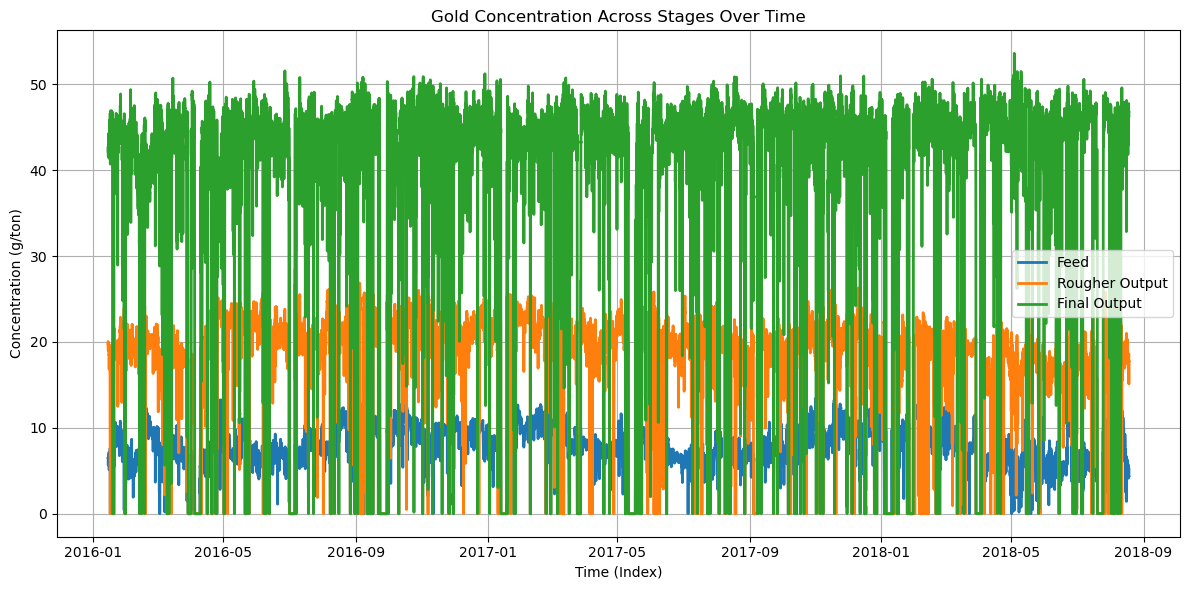

In [77]:
# Gold Concetrations over time in each stage

plt.figure(figsize=(12, 6))

plt.plot(full_data_filled['rougher.input.feed_au'], label='Feed', linewidth=2)
plt.plot(full_data_filled['rougher.output.concentrate_au'], label='Rougher Output', linewidth=2)
plt.plot(full_data_filled['final.output.concentrate_au'], label='Final Output', linewidth=2)

plt.title('Gold Concentration Across Stages Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Concentration (g/ton)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Looking at the progression of the gold concentrations over time we can see a very consistent output and clear distinction between all three stages. We're also seeing a gradual progression of greater concentrations at each stage indicating that the purifications processes for gold are effective and producing favorable output. 

</div>

#### Silver Concentrations

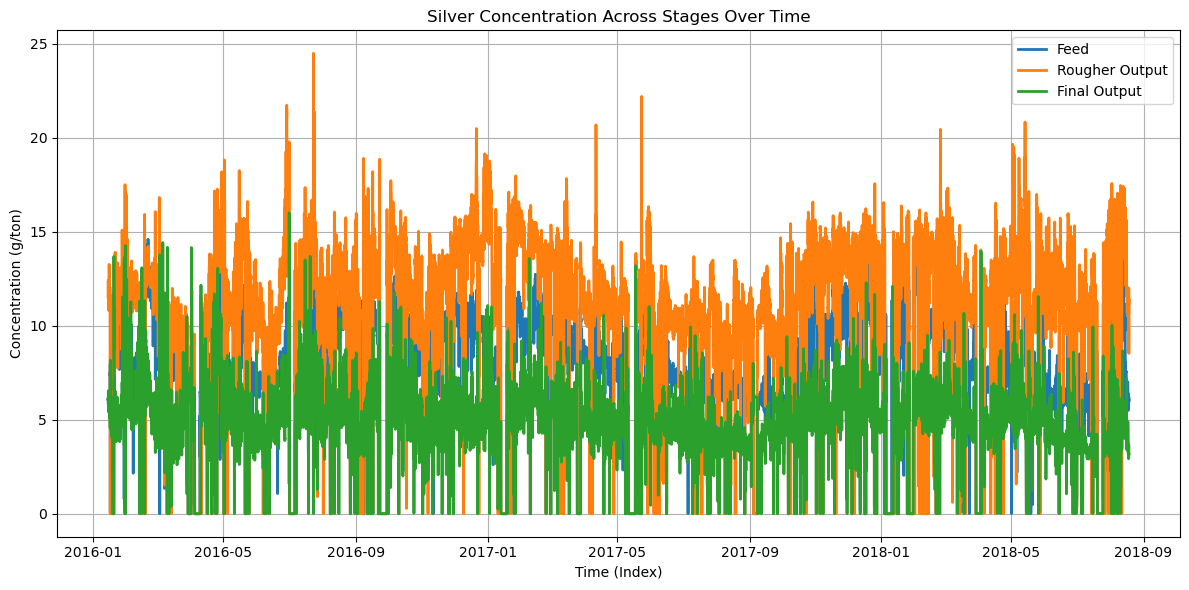

In [82]:
# Silver Concetrations over time in each stage

plt.figure(figsize=(12, 6))

plt.plot(full_data_filled['rougher.input.feed_ag'], label='Feed', linewidth=2)
plt.plot(full_data_filled['rougher.output.concentrate_ag'], label='Rougher Output', linewidth=2)
plt.plot(full_data_filled['final.output.concentrate_ag'], label='Final Output', linewidth=2)

plt.title('Silver Concentration Across Stages Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Concentration (g/ton)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border: 2px solid black; padding: 10px; margin: 10px">

As we take a look at our concentrations of silver throughout the purification processes, we see an odd result where the "Final Output" concentration value is lower than both the "Feed" and "Rougher Output" concentration levels. Following each stage, we can see that the "Rougher Output" value is slightly higher than the initial feed concetration value, which is a result in the right direction. Once we look at the variance between the "Rougher Output" values and the "Final Output" values, we raise questions as to the efficiency of the system between these two points. It seems the purification process needs more attention here when it comes to the concentrations of silver.

</div>

#### Lead Concentrations

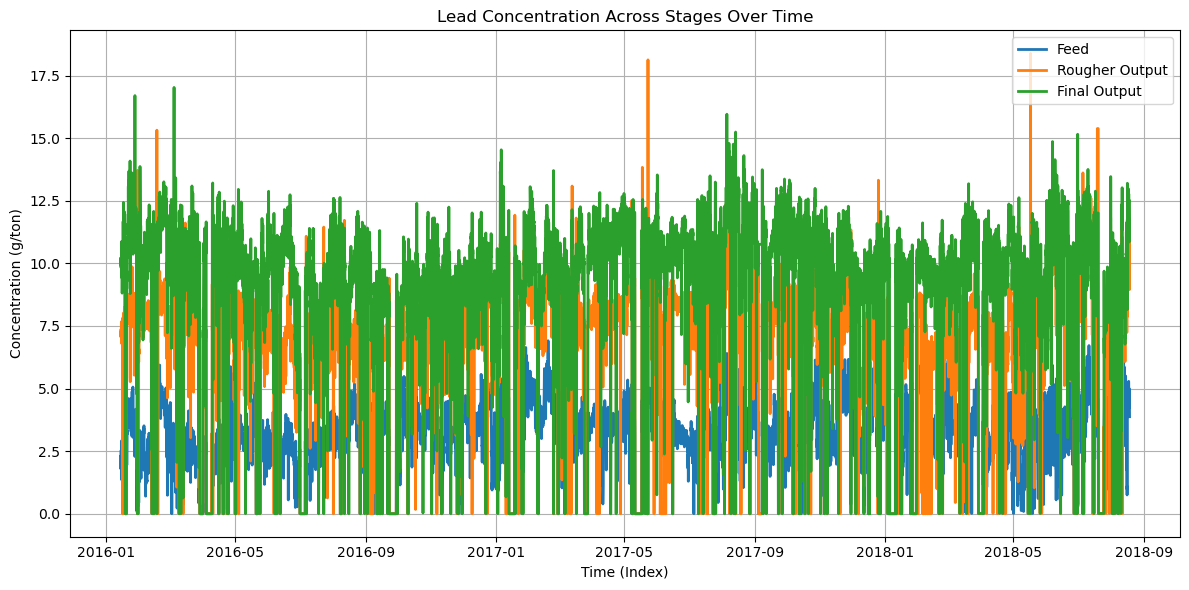

In [87]:
# Lead Concetrations over time in each stage

plt.figure(figsize=(12, 6))

plt.plot(full_data_filled['rougher.input.feed_pb'], label='Feed', linewidth=2)
plt.plot(full_data_filled['rougher.output.concentrate_pb'], label='Rougher Output', linewidth=2)
plt.plot(full_data_filled['final.output.concentrate_pb'], label='Final Output', linewidth=2)

plt.title('Lead Concentration Across Stages Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Concentration (g/ton)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Our visualization here of lead concentrations at each stage tell a slightly different story, though, a positive one. It's showing the expected progression of concentration levels at each stage. We do see, though, very slow increases in concentrations of lead through each stage which at least warrants an investigation as to the purification processes for lead and if they're efficiently extracting the maximum amount of product from the feed. 

</div>

### Comparing Feed Particle Size

<div style="border: 2px solid black; padding: 10px; margin: 10px">

For this analysis, we will first identify the features related to particle size in the <b>training set</b> and in the <b>test set</b>. <br>

Then, we will analyze a visual representation of the distributions for particle sizes. <br>

Lastly, we'll calculate some descriptive statistics for a clearer picture of their relationships. 

</div>

In [93]:
# Identifying the features related to particle size

# Training Set
feed_size_features_train = [col for col in train_data_filled.columns if 'feed_size' in col.lower()]
print("Feed size features found in Training set:")
for feature in feed_size_features_train:
    print(f"- {feature}")

print()

# Test Set
feed_size_features_test = [col for col in test_data_filled.columns if 'feed_size' in col.lower()]
print("Feed size features found in Test set:")
for feature in feed_size_features_test:
    print(f"- {feature}")

Feed size features found in Training set:
- primary_cleaner.input.feed_size
- rougher.input.feed_size

Feed size features found in Test set:
- primary_cleaner.input.feed_size
- rougher.input.feed_size


<div style="border: 2px solid black; padding: 10px; margin: 10px">

We have the same two features present in both the <b>Training</b> and <b>Test</b> sets.

</div>

/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_83222/2489054501.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Train', 'Test'])


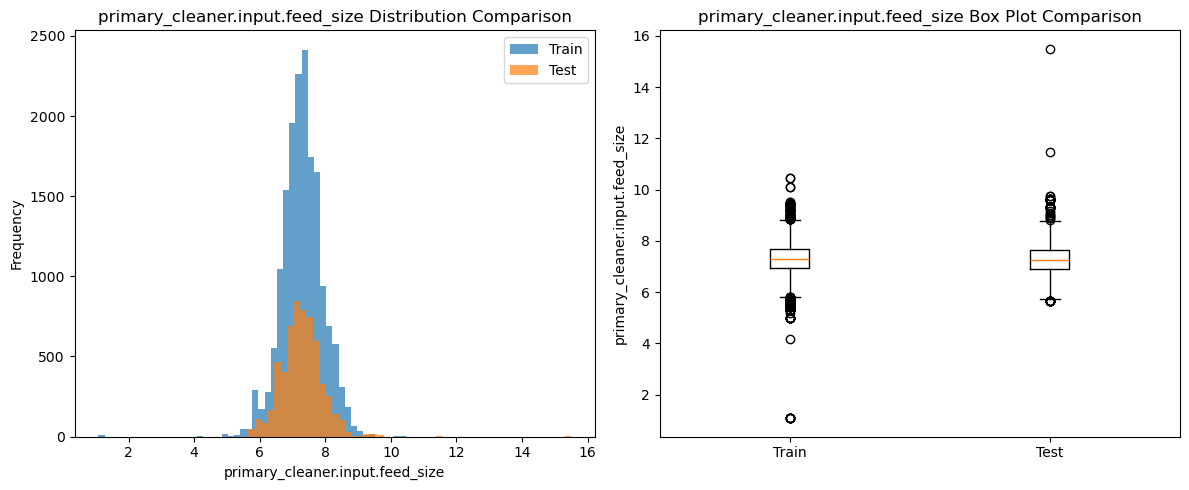

/var/folders/cp/t29hkt5j2055mnz846g13b000000gn/T/ipykernel_83222/2489054501.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Train', 'Test'])


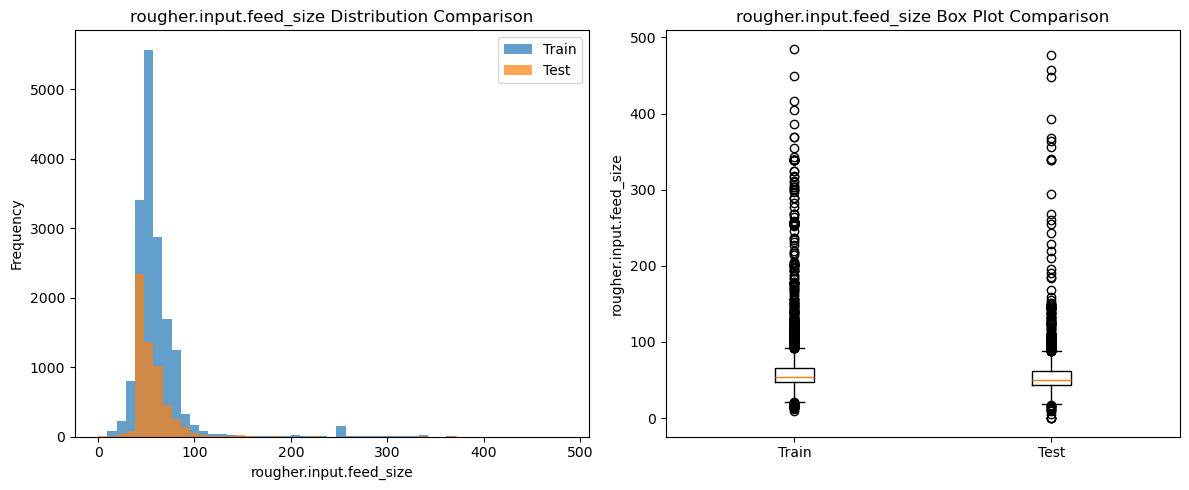

In [97]:
# Comparing distributions with histograms & boxplots

for feature in feed_size_features_train:
    plt.figure(figsize=(12, 5))
    
    # Plot training set distribution
    plt.subplot(1, 2, 1)
    plt.hist(train_data_filled[feature].dropna(), bins=50, alpha=0.7, label='Train')
    plt.hist(test_data_filled[feature].dropna(), bins=50, alpha=0.7, label='Test')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} Distribution Comparison')
    plt.legend()
    
    # Plot box plots for comparison
    plt.subplot(1, 2, 2)
    data_to_plot = [train_data_filled[feature].dropna(), test_data_filled[feature].dropna()]
    plt.boxplot(data_to_plot, labels=['Train', 'Test'])
    plt.ylabel(feature)
    plt.title(f'{feature} Box Plot Comparison')
    
    plt.tight_layout()
    plt.show()

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Seeing the distributions between the particle sizes in the train and test sets we can see that there is not a lot of variance between the two. This is favorable because it adds validity to the model's results after its evaluations of the data.

</div>

In [101]:
# Comparing Descriptive Statistics for both

for feature in feed_size_features_train:
    print(f"\n=== {feature} ===")
    print("Training Set:")
    print(train_data_filled[feature].describe())
    print("\nTest Set:")
    print(test_data_filled[feature].describe())
    
    # Calculate the difference in means
    train_mean = train_data_filled[feature].mean()
    test_mean = test_data_filled[feature].mean()
    print(f"\nMean difference: {abs(train_mean - test_mean):.4f}")


=== primary_cleaner.input.feed_size ===
Training Set:
count    16860.000000
mean         7.297285
std          0.619166
min          1.080000
25%          6.940000
50%          7.285000
75%          7.700000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

Test Set:
count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Mean difference: 0.0326

=== rougher.input.feed_size ===
Training Set:
count    16860.000000
mean        60.188595
std         30.522242
min          9.659576
25%         47.548897
50%         54.066003
75%         65.397249
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test Set:
count    5856.000000
mean       55.898866
std        22.707969
min         0.046369
25%        43.852884
50%        49.964796
75%        61.628003
max       477.445473
Name: rou

<div style="border: 2px solid black; padding: 10px; margin: 10px">

The mean difference for the <b>"primary_cleaner.input.feed_size"</b> is very low indicating a high congruency. <br>

The mean difference for the <b>"rougher.input.feed_size"</b> variable is greater, but still not significant where it could skew our predictions from our model.

</div>

### Comparing All Substance Concentrations

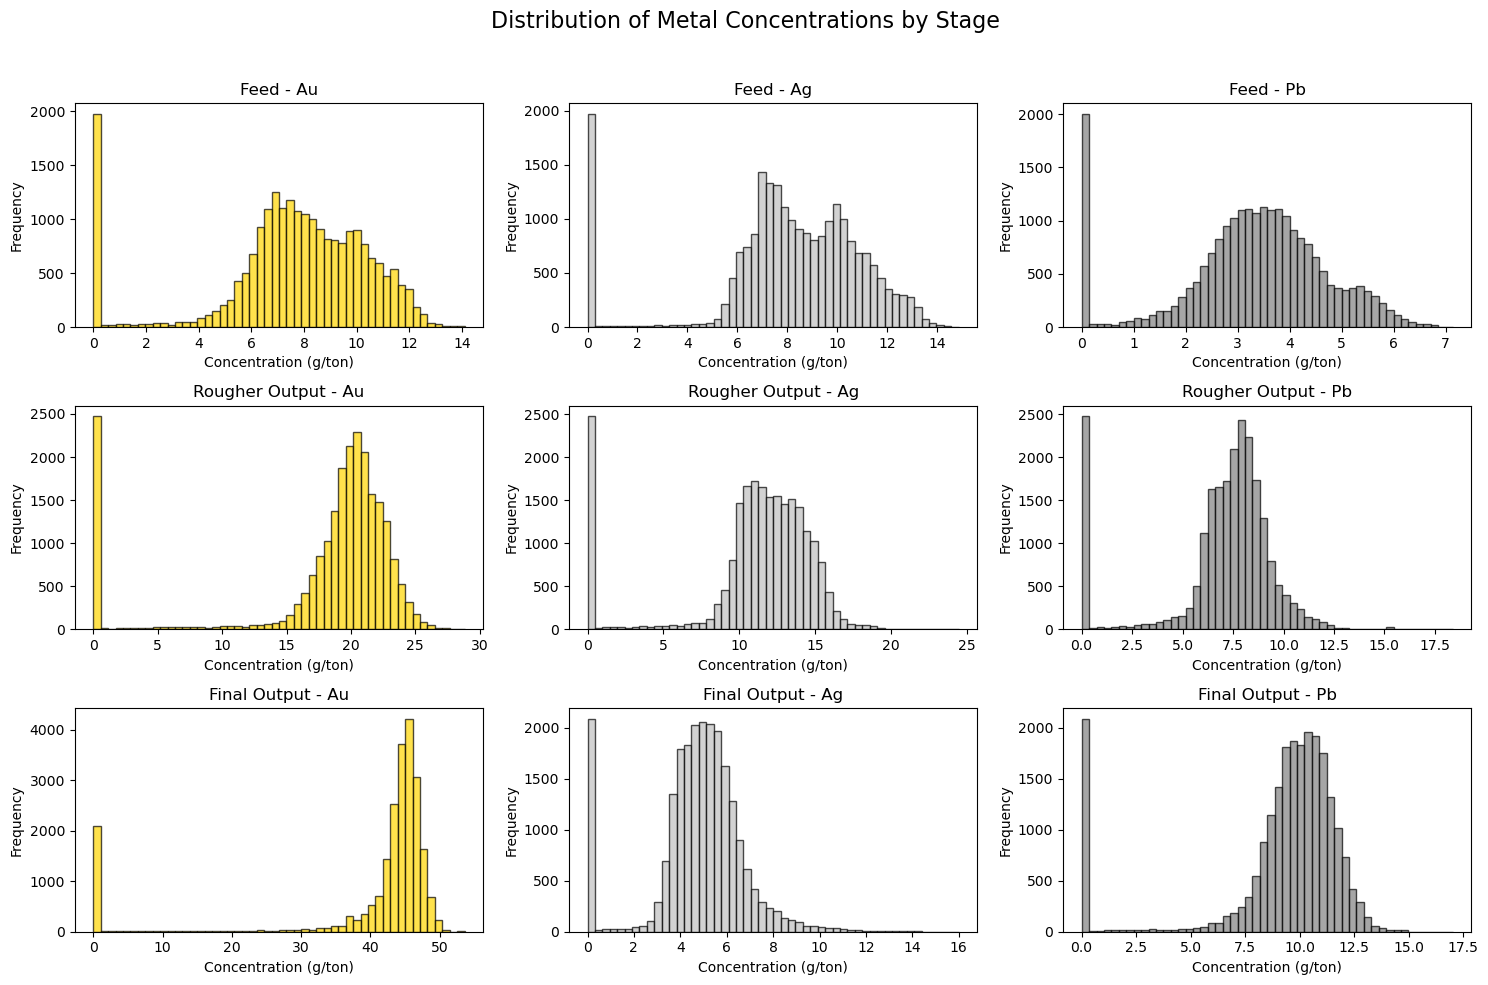

In [106]:
# First we'll define the variable groups by stage

variables = {
    'Feed': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'],
    'Rougher Output': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb'],
    'Final Output': ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']
}

elements = ['Au', 'Ag', 'Pb']
colors = ['gold', 'silver', 'gray']

# Creating subplots: 3 rows (stages) x 3 columns (elements)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Distribution of Metal Concentrations by Stage', fontsize=16)

# Plot histograms
for row_idx, (stage, cols) in enumerate(variables.items()):
    for col_idx, col in enumerate(cols):
        ax = axes[row_idx, col_idx]
        ax.hist(full_data_filled[col], bins=50, color=colors[col_idx], edgecolor='black', alpha=0.7)
        ax.set_title(f'{stage} - {elements[col_idx]}')
        ax.set_xlabel('Concentration (g/ton)')
        ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<div style="border: 2px solid black; padding: 10px; margin: 10px">

From the distributions, we can see the most noteworthy outliers are the "0" values in each stage and substance. We will investigate these zeros to see if they need to be removed or if they can stay and add the to the model effectiveness.

</div>

In [109]:
# Counting Zeros in the Training and Test sets

# Defining features that exist in both data sets
available_concentration_features = [
    'rougher.input.feed_au', 
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb'
]

print("=== TRAINING SET ZEROS ===")
for feature in available_concentration_features:
    zero_count = (train_data_filled[feature] == 0).sum()
    total_count = len(train_data_filled[feature])
    percentage = (zero_count / total_count) * 100
    print(f"{feature}: {zero_count} zeros ({percentage:.1f}%)")

print("\n=== TEST SET ZEROS ===")
for feature in available_concentration_features:
    zero_count = (test_data_filled[feature] == 0).sum()
    total_count = len(test_data_filled[feature])
    percentage = (zero_count / total_count) * 100
    print(f"{feature}: {zero_count} zeros ({percentage:.1f}%)")

=== TRAINING SET ZEROS ===
rougher.input.feed_au: 1213 zeros (7.2%)
rougher.input.feed_ag: 1213 zeros (7.2%)
rougher.input.feed_pb: 1222 zeros (7.2%)

=== TEST SET ZEROS ===
rougher.input.feed_au: 371 zeros (6.3%)
rougher.input.feed_ag: 371 zeros (6.3%)
rougher.input.feed_pb: 371 zeros (6.3%)


<div style="border: 2px solid black; padding: 10px; margin: 10px">

Although the amount of zeros is equal among their respective datasets, we will remove them to ensure that we're getting an accurate a result as possible.<br>

We're not sure if the zeros represent actual, beneficial, points of data that are adding value to our conclusions. We will remove the entire rows that contain our outlier, zero.

</div>

In [112]:
# Removing rows where zeros are present in each dataset

# Training dataset
mask_train = (train_data_filled[available_concentration_features] != 0).all(axis=1)
train_data_no_zeros = train_data_filled[mask_train]

# Test dataset
mask_test = (test_data_filled[available_concentration_features] != 0).all(axis=1)
test_data_no_zeros = test_data_filled[mask_test]

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Here we have isolated the rows that <b>do not</b> equal zero, and then reassigned them to a new dataframe for future calculations.

</div>

In [115]:
# Validating that zeros have been removed

print("=== TRAINING SET ZEROS VALIDATION ===")
for feature in available_concentration_features:
    zero_count = (train_data_no_zeros[feature] == 0).sum()
    total_count = len(train_data_no_zeros[feature])
    percentage = (zero_count / total_count) * 100
    print(f"{feature}: {zero_count} zeros ({percentage:.1f}%)")

print("\n=== TEST SET ZEROS VALIDATION ===")
for feature in available_concentration_features:
    zero_count = (test_data_no_zeros[feature] == 0).sum()
    total_count = len(test_data_no_zeros[feature])
    percentage = (zero_count / total_count) * 100
    print(f"{feature}: {zero_count} zeros ({percentage:.1f}%)")

=== TRAINING SET ZEROS VALIDATION ===
rougher.input.feed_au: 0 zeros (0.0%)
rougher.input.feed_ag: 0 zeros (0.0%)
rougher.input.feed_pb: 0 zeros (0.0%)

=== TEST SET ZEROS VALIDATION ===
rougher.input.feed_au: 0 zeros (0.0%)
rougher.input.feed_ag: 0 zeros (0.0%)
rougher.input.feed_pb: 0 zeros (0.0%)


## Building the Model

### Calculating Final sMAPE Value

In [120]:
# Defining the function to calculate sMAPE

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    denominator = (np.abs(y_true) + np.abs(y_pred))

    # Avoiding division by zero
    non_zero = denominator != 0

    smape_value = np.mean(
        2.0 * np.abs(y_pred[non_zero] - y_true[non_zero]) / denominator[non_zero]
    ) * 100

    return smape_value

### Training Different Models

#### RandomForest Model

In [124]:
# Setting up code for model training

# Creating a make_scorer() wrapper for sMAPE function
smape_scorer = make_scorer(smape, greater_is_better=False)

# Setting up cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

################

# Defining target columns
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# Extracting features present in both dataframes
train_features = train_data_no_zeros.drop(columns=target_columns).columns.tolist()
test_features = test_data_no_zeros.columns.tolist()
common_features = list(set(train_features) & set(test_features))

# Training Set
features_train = train_data_no_zeros[common_features]
target_train = train_data_no_zeros[target_columns]
features_test = test_data_no_zeros[common_features]

################

# Initiating an models
base_model = RandomForestRegressor(max_depth=6, n_estimators=40 )
model = MultiOutputRegressor(base_model)

# Fitting final model
model.fit(features_train, target_train)

# Predicting on test data
predictions = model.predict(features_test)

# Cross-validation scoring
cv_scores = cross_val_score(model, features_train, target_train, cv=kfold, scoring=smape_scorer)
print("Cross-Validation sMAPE scores (negative due to scoring convention):", cv_scores)
print(f"Mean sMAPE: {-np.mean(cv_scores):.2f}%")

Cross-Validation sMAPE scores (negative due to scoring convention): [-10.66010458 -10.27235548 -10.60186727]
Mean sMAPE: 10.51%


#### XGBoost Model

In [128]:
# Initiating an models
base_model_2 = XGBRegressor()
model_2 = MultiOutputRegressor(base_model_2)

# Fitting final model
model_2.fit(features_train, target_train)

# Predicting on test data
predictions_2 = model_2.predict(features_test)

# Cross-validation scoring
cv_scores = cross_val_score(model, features_train, target_train, cv=kfold, scoring=smape_scorer)
print("Cross-Validation sMAPE scores (negative due to scoring convention):", cv_scores)
print(f"Mean sMAPE: {-np.mean(cv_scores):.2f}%")

Cross-Validation sMAPE scores (negative due to scoring convention): [-10.70272956 -10.23800617 -10.57164145]
Mean sMAPE: 10.50%


## Conclusions

<div style="border: 2px solid black; padding: 10px; margin: 10px">

Comparing the two models we've tested in this project, it seems that the RandomForest delivered marginally better predictive accuracy than did the XGBoost model. Although both scored low on the sMAPE scoring, XGBoost was still better and with further investigation and tuning could produce even better outcomes. It is also a better sMAPE score than if the outliers (zeros) were kept within the datasets (as previous experimentation revealed). 

</div>